In [0]:
import torch
import matplotlib.pyplot as plt
import torchvision as tv 
import cv2
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import pathlib
import re
from torch.utils.data import Dataset, DataLoader
import more_itertools as mit
from statistics import median, mean
import nltk
from nltk import FreqDist
from collections import Counter
from itertools import chain
from sklearn.preprocessing import LabelEncoder

In [0]:
# this two lines are for unzip file
!tar xzf drive/My\ Drive/alcon2019.tar.gz

In [0]:
# !cd alcon2019/dataset/train_kana
!find . -name ".*.jpg" -type f -delete

In [4]:
# kana initial parameters
three_train_dir = 'alcon2019/dataset/train/imgs/'
three_train_label_csv = 'alcon2019/dataset/train/annotations.csv'
three_test_dir = 'alcon2019/dataset/test/imgs/'
batch_size = 32
num_workers = 4
num_epochs = 10
train_norm = ([0.56], [0.22])
test_norm = ([0.42], [0.20])
resize_size = (224, 224)

# three kana initial parameters
three_train_transform = tv.transforms.Compose([
        tv.transforms.Grayscale(),
        tv.transforms.Resize(resize_size),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(*train_norm)
])

three_test_transform = tv.transforms.Compose([
        tv.transforms.Grayscale(),
        tv.transforms.Resize(resize_size),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(*test_norm)
])

classes = ['U+3042', 'U+3044', 'U+3046', 'U+3048', 'U+304A', 'U+304B', 'U+304D', 'U+304F', 
           'U+3051', 'U+3053', 'U+3055', 'U+3057', 'U+3059', 'U+305B', 'U+305D', 'U+305F', 
           'U+3061', 'U+3064', 'U+3066', 'U+3068', 'U+306A', 'U+306B', 'U+306C', 'U+306D', 
           'U+306E', 'U+306F', 'U+3072', 'U+3075', 'U+3078', 'U+307B', 'U+307E', 'U+307F', 
           'U+3080', 'U+3081', 'U+3082', 'U+3084', 'U+3086', 'U+3088', 'U+3089', 'U+308A', 
           'U+308B', 'U+308C', 'U+308D', 'U+308F', 'U+3090', 'U+3091', 'U+3092', 'U+3093']
num_kana_classes = len(classes)
le = LabelEncoder()
le.fit(classes)

LabelEncoder()

In [0]:
"""
this is all the function and class definition
"""

class ThreeKanaDataset(Dataset):
    """Three characters train dataset."""
    
    def __init__(self, root_dir, kana_pos=None, csv_file=None, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations(not necessary if it's test dir).
            transform (callable, optional): Optional transform to be applied on a sample.
            norm (tupple): for normalize
        """
        if csv_file:
            tmp = pd.read_csv(csv_file)
            self.labels = [le.transform(tmp['Unicode1'].values.tolist()), 
                      le.transform(tmp['Unicode2'].values.tolist()), 
                      le.transform(tmp['Unicode3'].values.tolist())]
        train_root = pathlib.Path(root_dir)
        all_image_paths = [str(path) for path in train_root.glob('*')]
        all_image_paths.sort(key=lambda x: int(re.findall(r'\d+(?=\.jpg)', x)[0]))
        self.all_image_paths = all_image_paths
        self.transform = transform
        self.kana_pos = kana_pos
        self.csv_file = csv_file 



    def __len__(self):
        return len(self.all_image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.all_image_paths[idx])
        img = tv.transforms.functional.to_pil_image(img)
        if self.transform:
            img = self.transform(img)
        
        if self.csv_file and self.kana_pos != None:
            return {'image': img, 'label': self.labels[self.kana_pos][idx]}
        else:
            return {'image': img}
   
      

def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)



    
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))
    model.eval()   
    


  
    

In [0]:
# three kana dataset
u1_dataset = ThreeKanaDataset(csv_file=three_train_label_csv, kana_pos=0, root_dir=three_train_dir, transform=three_train_transform)
u2_dataset = ThreeKanaDataset(csv_file=three_train_label_csv, kana_pos=1, root_dir=three_train_dir, transform=three_train_transform)
u3_dataset = ThreeKanaDataset(csv_file=three_train_label_csv, kana_pos=2, root_dir=three_train_dir, transform=three_train_transform)
train_size = int(0.8 * len(u1_dataset))
test_size = len(u1_dataset) - train_size
u1_train_dataset, u1_test_dataset = torch.utils.data.random_split(u1_dataset, [train_size, test_size])
u2_train_dataset, u2_test_dataset = torch.utils.data.random_split(u2_dataset, [train_size, test_size])
u3_train_dataset, u3_test_dataset = torch.utils.data.random_split(u3_dataset, [train_size, test_size])
test_dataset = ThreeKanaDataset(root_dir=three_test_dir, transform=three_test_transform)

u1_train_loader = torch.utils.data.DataLoader(u1_train_dataset,batch_size=batch_size, shuffle=True,num_workers=num_workers)
u2_train_loader = torch.utils.data.DataLoader(u2_train_dataset,batch_size=batch_size, shuffle=True,num_workers=num_workers)
u3_train_loader = torch.utils.data.DataLoader(u3_train_dataset,batch_size=batch_size, shuffle=True,num_workers=num_workers)
u1_test_loader = torch.utils.data.DataLoader(u1_test_dataset,batch_size=batch_size, shuffle=True,num_workers=num_workers)
u2_test_loader = torch.utils.data.DataLoader(u2_test_dataset,batch_size=batch_size, shuffle=True,num_workers=num_workers)
u3_test_loader = torch.utils.data.DataLoader(u3_test_dataset,batch_size=batch_size, shuffle=True,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, num_workers=num_workers)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


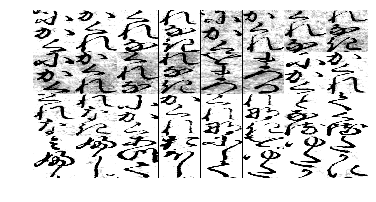

In [63]:
def show_sample(loader):
    for i_batch, sample_batched in enumerate(loader):
        print(i_batch)

        # observe 4th batch and stop.
        if i_batch == 0:
            plt.figure()
            grid = tv.utils.make_grid(sample_batched['image'])
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.axis('off')
#             plt.title(str(sample_batched['label']))
            plt.show()
            break
show_sample(test_loader)

In [0]:
u1_model = tv.models.resnet50()
u2_model = tv.models.resnet50()
u3_model = tv.models.resnet50()
u1_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)
u2_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)
u3_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
u1_model = u1_model.to(device)
u2_model = u2_model.to(device)
u3_model = u3_model.to(device)
u1_cri = nn.CrossEntropyLoss()
u2_cri = nn.CrossEntropyLoss()
u3_cri = nn.CrossEntropyLoss()
u1_opt = optim.SGD(u1_model.parameters(), lr=0.001, momentum=0.9)
u2_opt = optim.SGD(u2_model.parameters(), lr=0.001, momentum=0.9)
u3_opt = optim.SGD(u3_model.parameters(), lr=0.001, momentum=0.9)

In [15]:
device

device(type='cuda', index=0)

In [0]:

def train_model(model, dataset, cri, opt):
    model.train()
    loss_values = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataset, 0):
            # get the inputs
            inputs, labels = data['image'], data['label']
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            opt.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = cri(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
        loss_values.append(running_loss / len(dataset))
        print('{} time: loss {}'.format(epoch, running_loss / len(dataset)))

    print('Finished Training')
# train_model()
# model.load_state_dict(torch.load('drive/My Drive/kana_cnn_95.pt'))
# model.eval()


In [0]:
def show_kana_accuracy(model, dataset):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataset:
            inputs, labels = data['image'], data['label']
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            softmax_arr = nn.functional.softmax(outputs.data, dim=1)
            _, predicted = torch.max(softmax_arr, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

In [18]:
train_model(u1_model, u1_train_loader, u1_cri, u1_opt)
show_kana_accuracy(u1_model, u1_test_loader)
save_model(u1_model, 'u1_model.pt')


0 time: loss 3.463777571280797
1 time: loss 1.3459258939226468
2 time: loss 0.489295290718476
3 time: loss 0.26992163989444573
4 time: loss 0.16349400962640842
5 time: loss 0.0998715844321996
6 time: loss 0.06068252897945543
7 time: loss 0.03517921783526738
8 time: loss 0.020682085014879704
9 time: loss 0.012736093162869415
Finished Training
Accuracy of the network on the test images: 95 %


In [19]:
train_model(u2_model, u2_train_loader, u2_cri, u2_opt)
show_kana_accuracy(u2_model, u2_test_loader)
save_model(u2_model, 'u2_model.pt')


0 time: loss 3.6596177518367767
1 time: loss 2.1290795788963637
2 time: loss 0.8100312899053097
3 time: loss 0.40928521045545735
4 time: loss 0.24981297865509988
5 time: loss 0.16123690169801314
6 time: loss 0.10690269601345062
7 time: loss 0.07048743002985915
8 time: loss 0.04783626681690415
9 time: loss 0.03373184137170514
Finished Training
Accuracy of the network on the test images: 95 %


In [20]:
train_model(u3_model, u3_train_loader, u3_cri, u3_opt)
show_kana_accuracy(u3_model, u3_test_loader)
save_model(u3_model, 'u3_model.pt')

0 time: loss 3.4402521730264026
1 time: loss 1.5425518837869168
2 time: loss 0.638938599785169
3 time: loss 0.3537210465768973
4 time: loss 0.21854657122989496
5 time: loss 0.13940188308556875
6 time: loss 0.08749337850448986
7 time: loss 0.05291800683240096
8 time: loss 0.03305289354299506
9 time: loss 0.02049200610568126
Finished Training
Accuracy of the network on the test images: 94 %


In [0]:
def get_test_answer():
    u1_predict, u2_predict, u3_predict = [], [], []
    u1_model.eval()
    u2_model.eval()
    u3_model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs= data['image']
            inputs = inputs.to(device)
            
            output1 = u1_model(inputs)
            softmax_arr1 = nn.functional.softmax(output1.data, dim=1)
            _, predict1 = torch.max(softmax_arr1, 1)
            
            output2 = u2_model(inputs)
            softmax_arr2 = nn.functional.softmax(output2.data, dim=1)
            _, predict2 = torch.max(softmax_arr2, 1)
            
            output3 = u3_model(inputs)
            softmax_arr3 = nn.functional.softmax(output3.data, dim=1)
            _, predict3 = torch.max(softmax_arr3, 1)
            
            u1_predict.extend(predict1.tolist())
            u2_predict.extend(predict2.tolist())
            u3_predict.extend(predict3.tolist())
    return [list(range(16387)), u1_predict, u2_predict, u3_predict]

In [0]:
predict_ans = get_test_answer()

In [0]:
def write_to_csv(arr, path):
    a = [classes[x] for x in arr[1]]
    b = [classes[x] for x in arr[2]]
    c = [classes[x] for x in arr[3]]
    pd.DataFrame(data={'ID': arr[0], 'Unicode1': a, 'Unicode2': b, 'Unicode3': c}).to_csv(path, index=False) 
write_to_csv(predict_ans, 'test_prediction.csv')